In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 12, repr.plot.height = 12) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
# Read the zip file from url and unzip so it can be loaded into a dataframe
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
zip_file <- tempfile(fileext = ".zip")
download.file(url, zip_file, mode = "wb")
student_data <- read_delim(unz(description = zip_file, filename = "student-mat.csv"), delim = ";")

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



In [5]:
# Grouped the Final Grade into intervals for easier labelling down the line
# Grades 0-5 is 1, 6-10 is 2, 11-15 is 3 and 16-20 is 4

student_data_group <- student_data %>%
    mutate(label = cut(G3, c(0, 9, 11, 13, 15, 20), 
                       #labels = c("fail", "sufficient", "satisfactory", "good", "excellent"), 
                       labels = c(1, 2, 3, 4, 5),
                       left = FALSE)) %>%
    group_by(label = as.factor(label)) %>%
    filter(!is.na(label))

head(student_data_group)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,3,3,1,1,3,4,5,5,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,15,U,GT3,T,4,2,health,services,⋯,2,2,1,1,5,2,15,14,15,4
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4


Columns with binary data are removed as we were informed that initially they would not make suitable factors in KNN classification.


In [6]:
student_data_group_no_bin <- student_data_group %>%
    select(Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3, label)

head(student_data_group_no_bin)

Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,1
1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,1
1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,2
4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,4
3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,2
4,3,1,2,0,5,4,2,1,2,5,10,15,15,15,4


In [7]:
# Split the data into training and testing set
#student_data_split <- initial_split(student_data_cleaned_binary, prop = 0.75, strata = label)
student_data_split <- initial_split(student_data_group_no_bin, prop = 0.75, strata = label)
student_train <- training(student_data_split)
student_test <- testing(student_data_split)


Preliminary data analysis to look at where the largest counts or average lies for certain factors.

In [8]:
# Exploratory Data Analysis
# Distribution of mother's education level
student_train_meduc <- group_by(student_train, Medu) %>%
    summarize(n = n())

# Distribution of father's education level
student_train_feduc <- group_by(student_train, Fedu) %>%
    summarize(n = n())

# Counts number of student failures
student_train_failure <- group_by(student_train, failures) %>%
    summarize(n=n())

# Counts number of student absences
student_train_absences <- group_by(student_train, absences) %>%
    summarize(n=n())

# Computes mean of student absences
student_train_absences_m <- group_by(student_train) %>%
    summarize(absences_m = mean(absences))

# Computes mean family relationship quality
student_train_famrel <- group_by(student_train) %>%
    summarize(famrel = mean(famrel))

# Computes mean overall health status
student_train_health <- group_by(student_train) %>%
    summarize(health = mean(health))

# Computes mean student travel time
student_train_travel <- group_by(student_train) %>%
    summarize(traveltime = mean(traveltime))

# Student final grade distribution
student_train_G3 <- group_by(student_train, G3) %>%
    summarize(n = n())

head(student_train_meduc)
head(student_train_feduc)
head(student_train_failure)
head(student_train_absences)
head(student_train_absences_m)
head(student_train_famrel)
head(student_train_health)
head(student_train_travel)
student_train_G3

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Medu,n
<dbl>,<int>
0,2
1,36
2,75
3,63
4,93


Fedu,n
<dbl>,<int>
0,1
1,53
2,79
3,66
4,70


failures,n
<dbl>,<int>
0,224
1,31
2,6
3,8


absences,n
<dbl>,<int>
0,55
1,2
2,50
3,8
4,41
5,4


absences_m
<dbl>
6.271375


famrel
<dbl>
3.944238


health
<dbl>
3.565056


traveltime
<dbl>
1.408922


G3,n
<dbl>,<int>
5,5
6,15
7,6
8,23
9,20
10,44
11,34
12,23
13,24


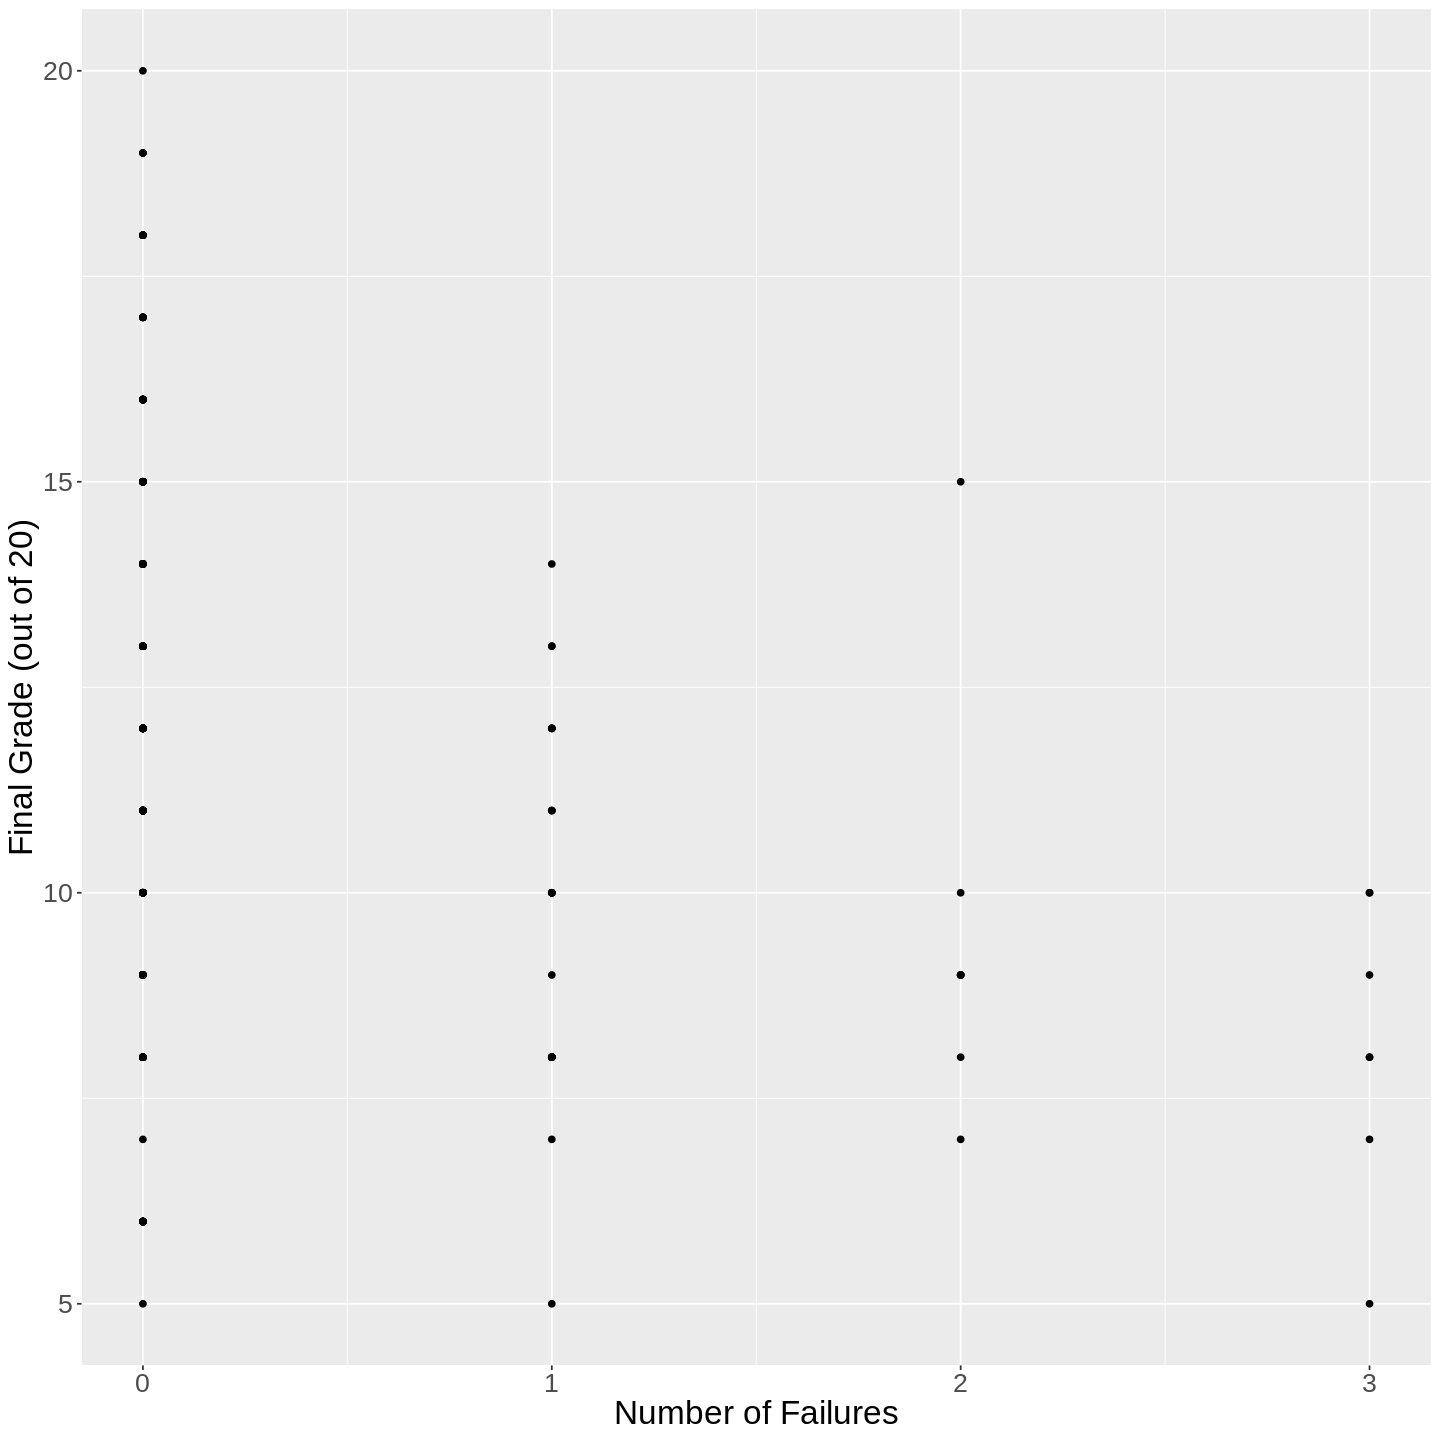

In [8]:
# Exploratory plot of Final Grade vs Number of Failures
student_plot <- ggplot(student_train, aes(x = failures, y = G3)) +
    geom_point() +
    labs(x = "Number of Failures" , y = "Final Grade (out of 20)") +
    theme(text = element_text(size = 20))
student_plot

From the above graph, due to the nature of the data itself, it is difficult to gleam any useful information. But we can see that those that achieve a high final grade would tend to have a fewer number of failures. We are also unable to tell the number of each people at each point from this graph.

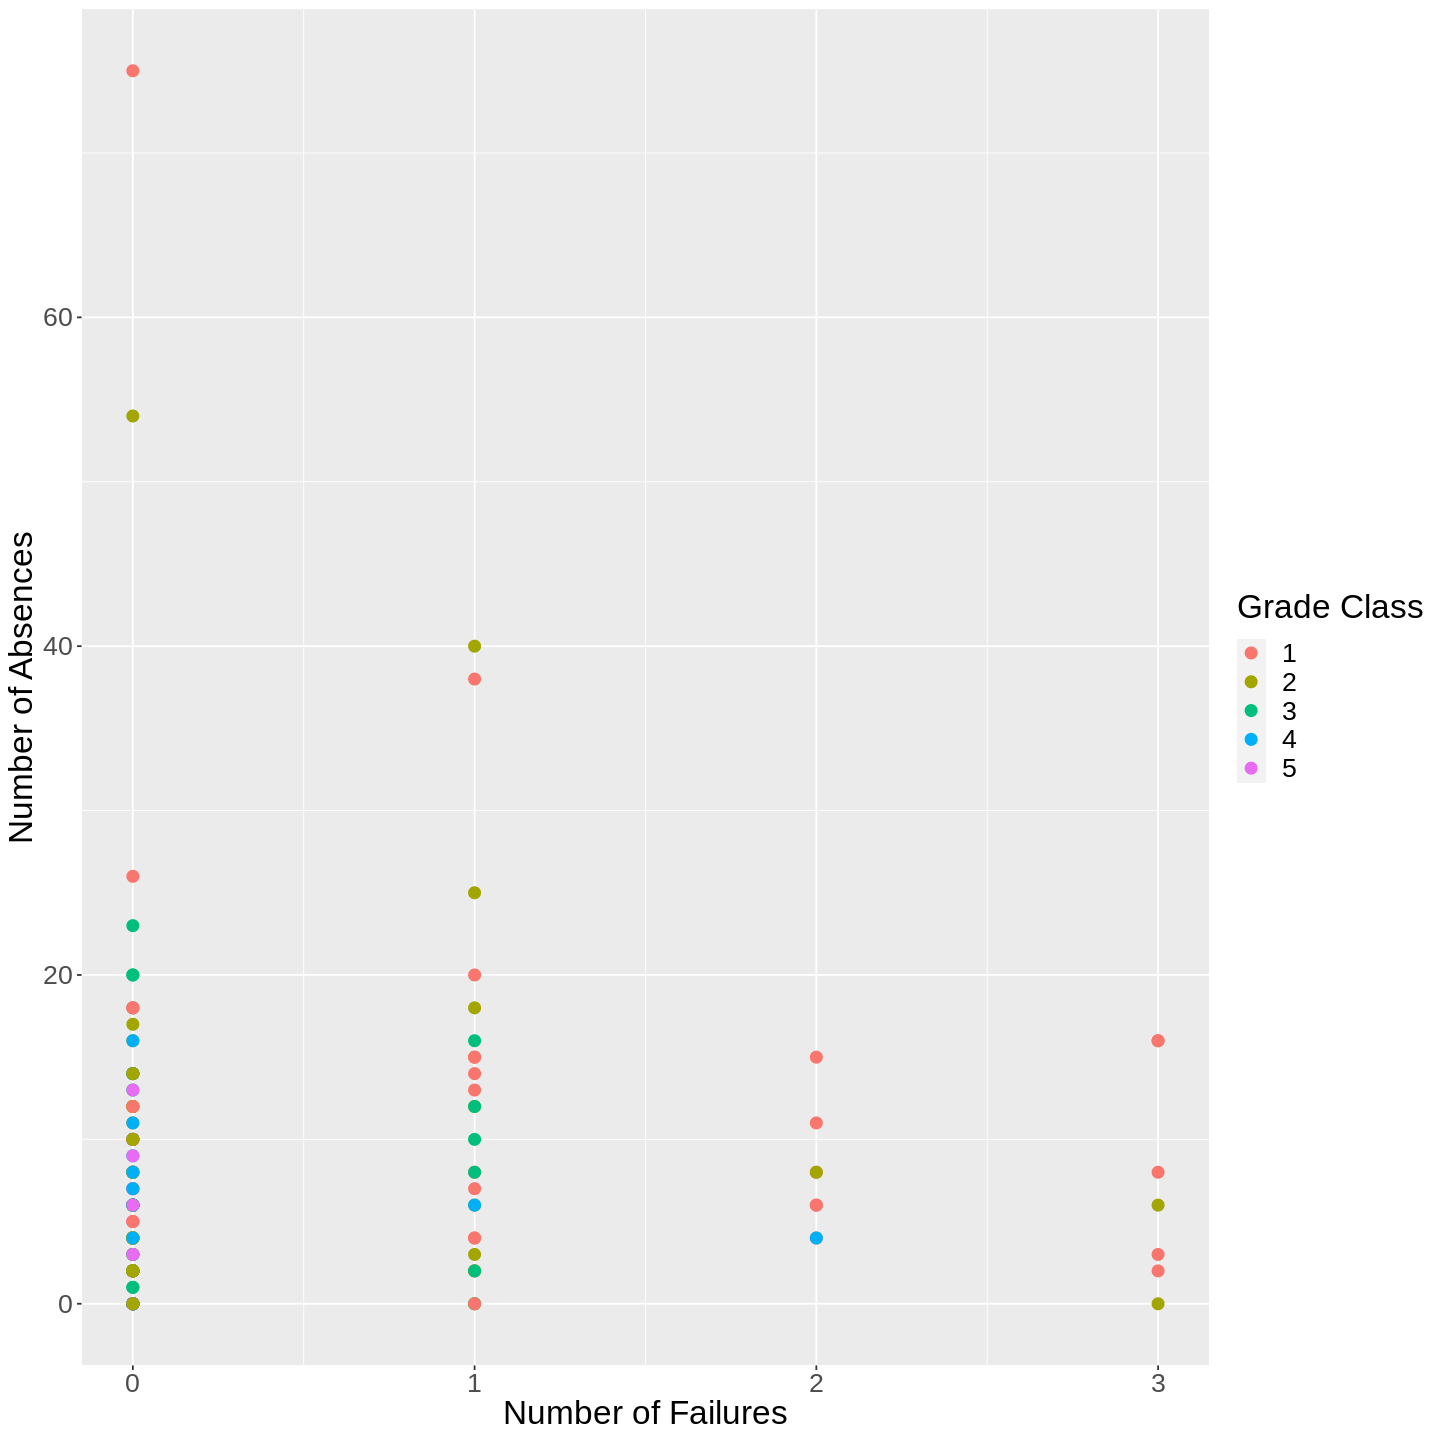

In [9]:
# Exporatory plot of Number of Absences vs Number of Failure with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = failures, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Number of Failures" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    theme(text = element_text(size = 20))
student_plot2

On this graph, the details are a bit more clear. One might expect a different distribution of data points on this graph, where the data points are more towards the top right of the graph meaning that those with a high number of class absences would also fail more classes. An important note here is that students who score a high grade in class both have low number of failures (0-1) and low number of absences (<20).

In [10]:
# model specification to produce a baseline accuracy

set.seed(2020)
# Medu + Fedu + studytime + failures + famrel + health + absences
student_recipe <- recipe(label ~ Medu + Fedu + studytime + failures  + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6840149
Best kernel: rectangular
Best k: 5

In [11]:
#
student_test_pred <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.25000000
kap,multiclass,0.02827505


          Truth
Prediction  1  2  3  4  5
         1 11  8  6  4  5
         2  4  5  3  6  2
         3  4  7  4  2  0
         4  3  3  1  2  3
         5  1  2  1  1  0

With 5 neighbours we found that the accuracy is only 26% and we can definitely do better. We will tune our classifier in order to increase our accuracy.

In [12]:
# cross-validation
student_vfold <- vfold_cv(student_train, v = 5, strata = label)

set.seed(2020)

student_recipe_2 <- recipe(label ~ Medu + Fedu + studytime + failures  + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2 <- workflow() %>%
    add_recipe(student_recipe_2) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2 %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2680361,5,0.01427252
roc_auc,hand_till,0.5689019,5,0.02274784


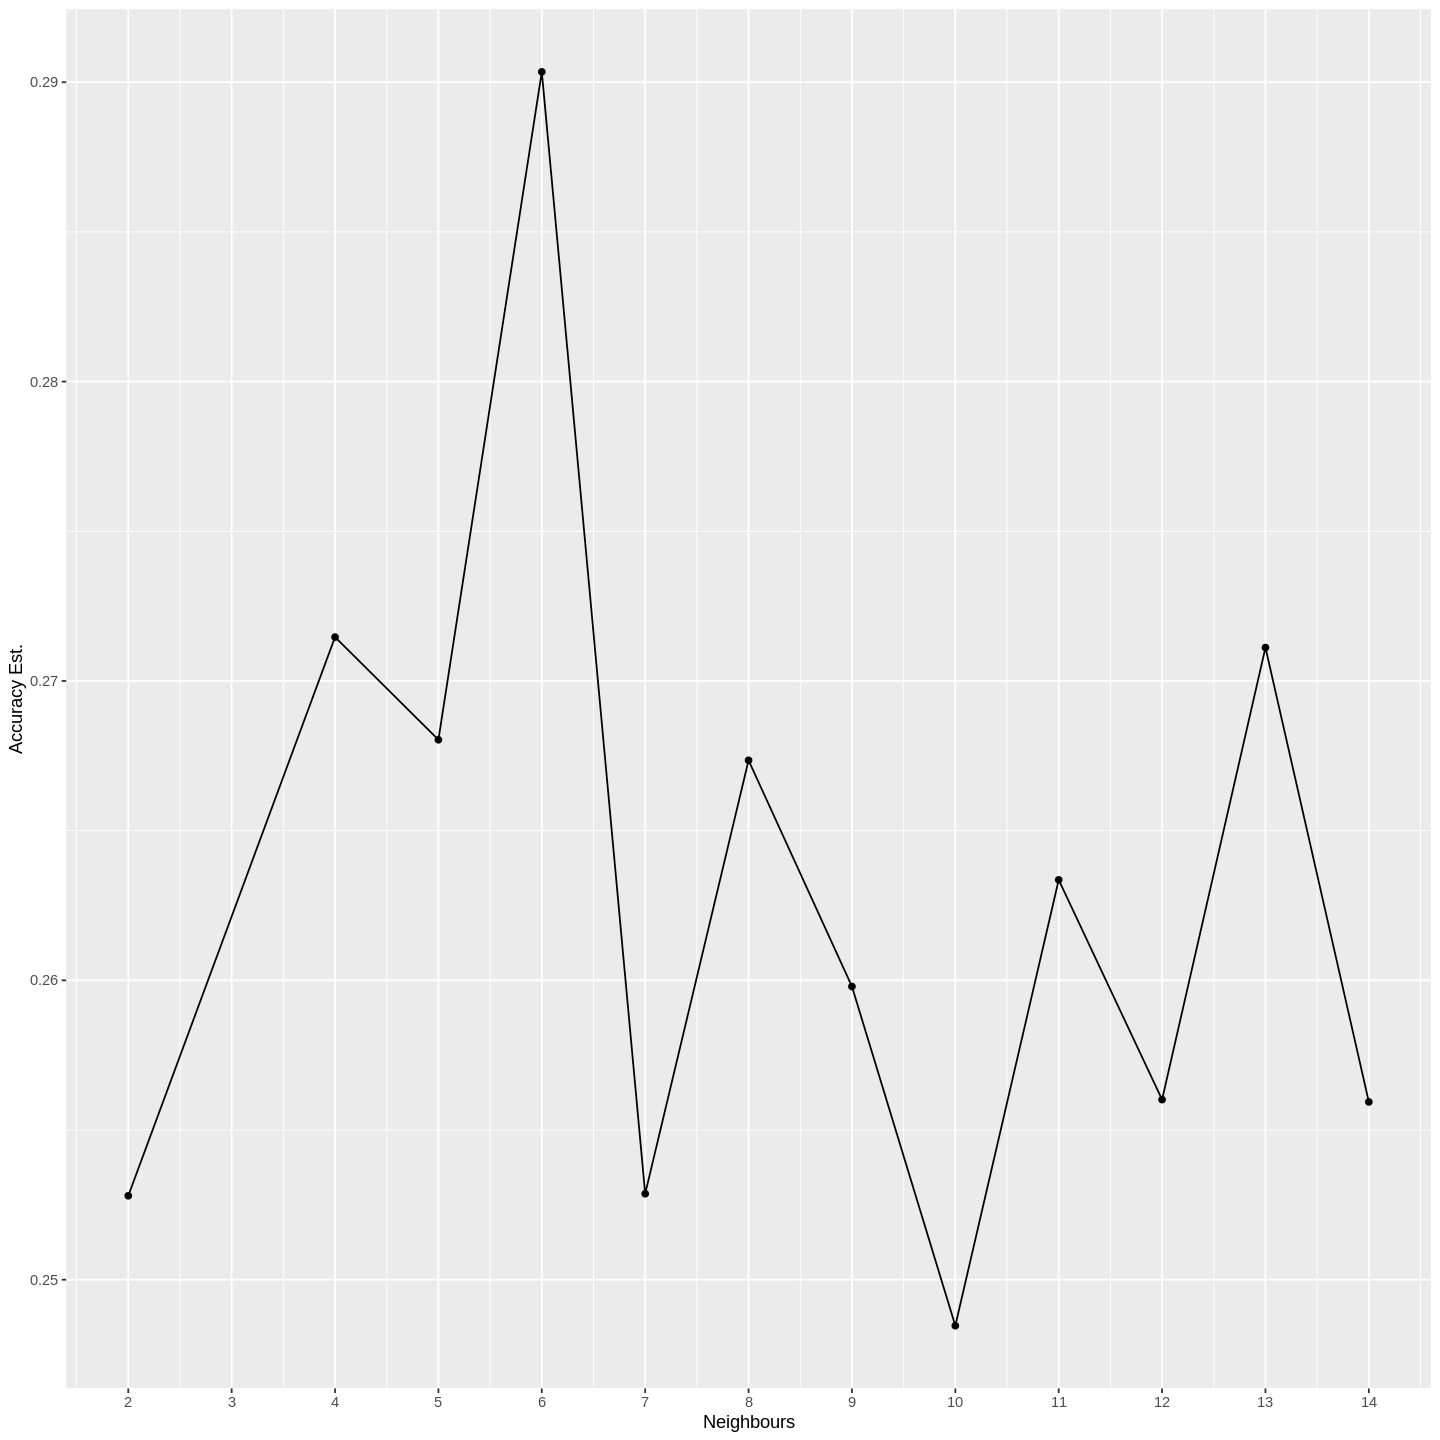

In [13]:
# Finding the best K by plotting accuracy vs K

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

set.seed(2020)

knn_results_tuned <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()


accuracies <- knn_results_tuned %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    scale_x_continuous(breaks = 1:15)
    
accuracy_vs_k

The visualization suggests that $K$ =  14 provides the highest accuracy. Unfortunately, the accuracy is only slightly above our previous $K$ of 5. With $K$ = 14, the accuracy increases to just over 30%, while at $K$ = 5, the accuracy was 26%.

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6951673
Best kernel: rectangular
Best k: 5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3295455
kap,multiclass,0.1205962


          Truth
Prediction  1  2  3  4  5
         1 12  6  2  2  3
         2  5 12  8  5  4
         3  2  5  2  3  2
         4  3  2  2  3  1
         5  1  0  1  2  0

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2740554,5,0.02434747
roc_auc,hand_till,0.5458696,5,0.01863659


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.1999426,5,0.02866450,Model01
2,accuracy,multiclass,0.1962389,5,0.02756481,Model02
3,accuracy,multiclass,0.2260886,5,0.02804525,Model03
4,accuracy,multiclass,0.2665728,5,0.02524457,Model04
6,accuracy,multiclass,0.2740606,5,0.02687553,Model05
7,accuracy,multiclass,0.2486864,5,0.02789471,Model06
8,accuracy,multiclass,0.2342187,5,0.02996317,Model07
9,accuracy,multiclass,0.2340737,5,0.02729970,Model08
10,accuracy,multiclass,0.2338641,5,0.04091663,Model09


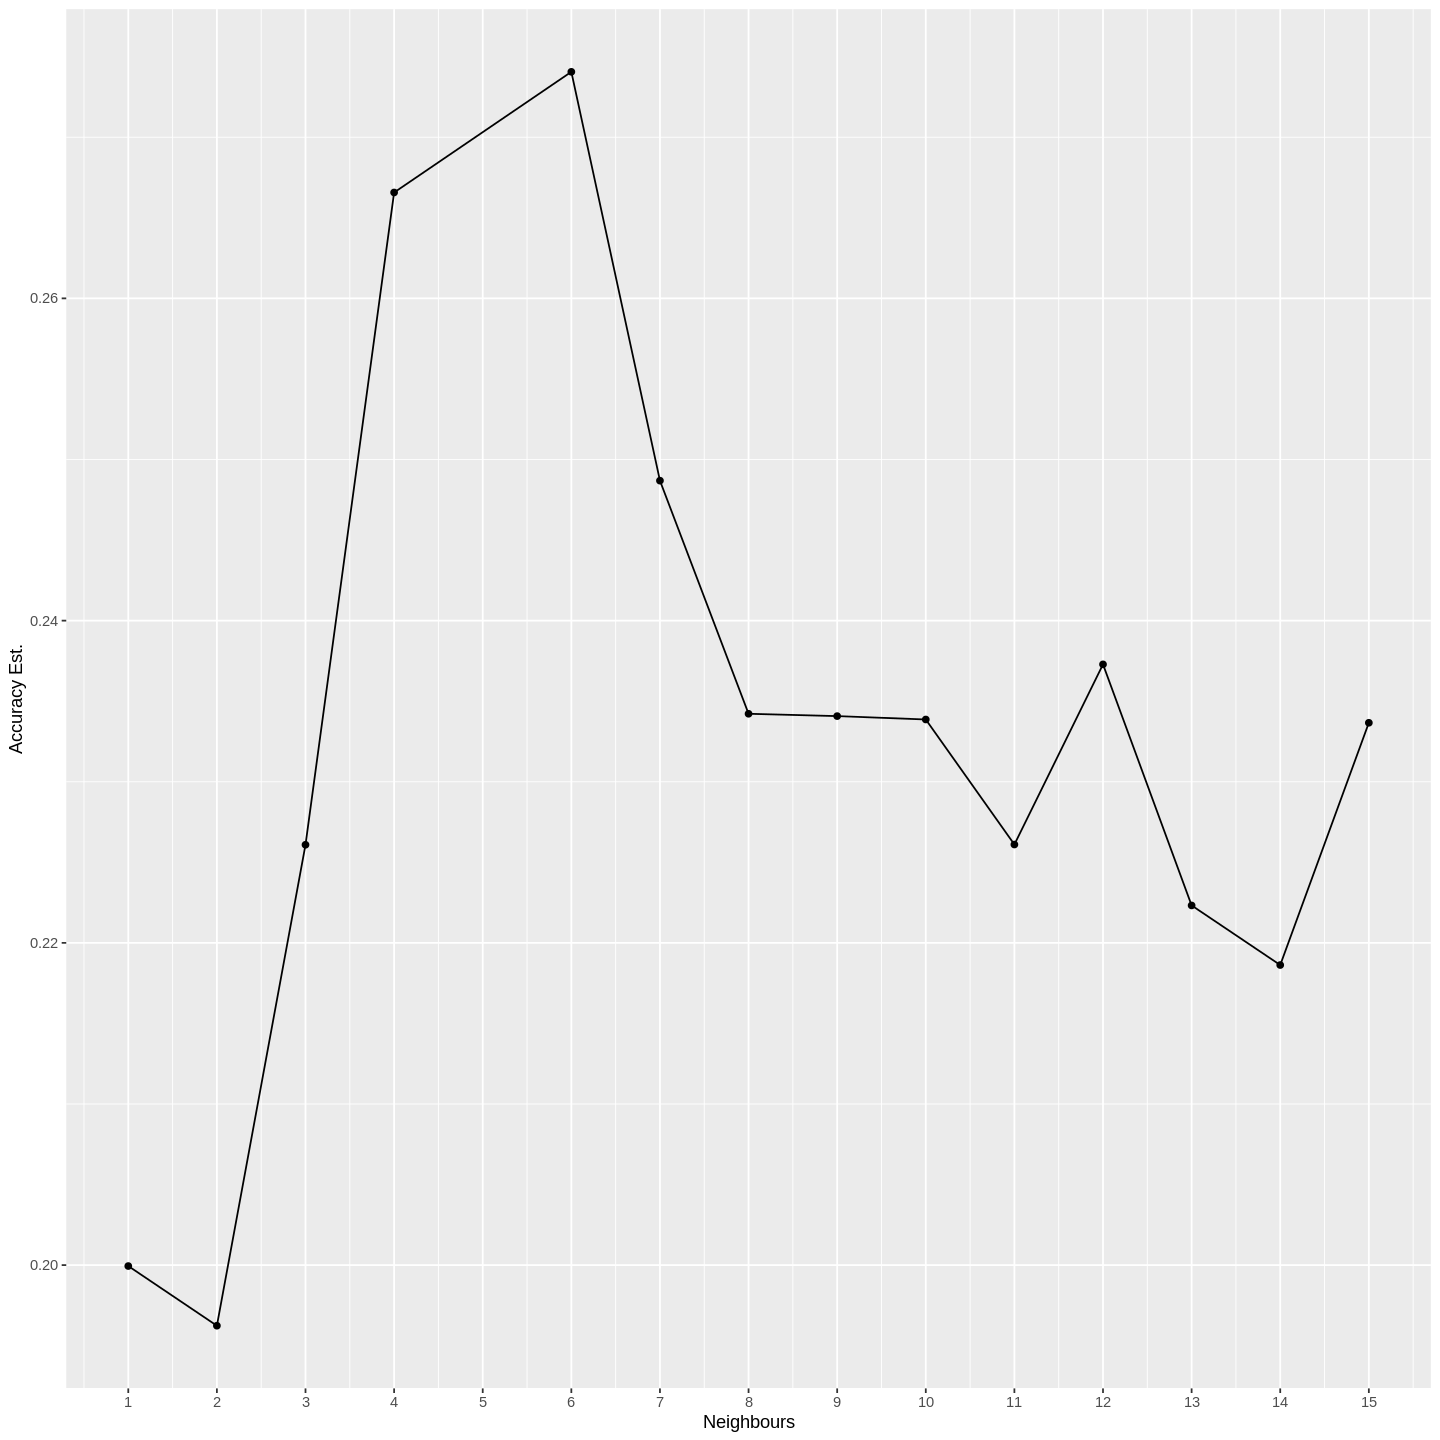

In [16]:
#### TEST

set.seed(2020)
# Medu + Fedu + studytime + failures + famrel + health + absences
student_recipe_time <- recipe(label ~ traveltime + goout + studytime + freetime + health + absences , 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit_time <- workflow() %>%
     add_recipe(student_recipe_time) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit_time

student_test_pred <- predict(knn_fit_time, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

student_vfold <- vfold_cv(student_train, v = 5, strata = label)


student_recipe_2_time <- recipe(label ~  traveltime  + goout + studytime + freetime + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2_time <- workflow() %>%
    add_recipe(student_recipe_2_time) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2_time %>% collect_metrics()

knn_spec_tune_time <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")


knn_results_tuned_time <- workflow() %>%
    add_recipe(student_recipe_time) %>%
    add_model(knn_spec_tune_time) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()

accuracies <- knn_results_tuned_time %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    scale_x_continuous(breaks = 1:15)
    
accuracies
accuracy_vs_k

In [22]:
# Now we'll perform KNN on our test data with K = 6

#creating our final KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# centering/scaling recipe
student_recipe <- recipe(label ~ traveltime + goout + studytime + freetime + health + absences , 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

# making our workflow
knn_fit <- workflow() %>%
     add_recipe(student_recipe_time) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

# predicting labels on test set
student_test_preds <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

head(student_test_preds)



.pred_class,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,2
2,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,4
2,2,2,1,2,0,4,4,4,1,1,3,0,12,12,11,2
4,4,4,2,2,0,4,1,4,1,1,1,6,6,5,6,1
4,3,2,1,2,0,4,2,2,1,1,1,0,16,18,19,5
1,4,4,1,2,0,3,3,3,1,2,2,0,10,8,9,1


In [23]:
# computing the accuracy of our model

student_test_preds %>%
    metrics(truth = label, estimate = .pred_class)

# confusion matrix

student_test_preds %>%
    conf_mat(truth = label, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.3522727
kap,multiclass,0.1492537


          Truth
Prediction  1  2  3  4  5
         1 12  6  2  2  4
         2  6 14  8  5  2
         3  2  4  2  3  2
         4  2  1  2  2  1
         5  1  0  1  3  1

Using our KNN model with K = 6, we were able to predict a student's final grade with an accuracy of 35%.